# **Corresponde a práctico de Aprendizaje NO Supervisado ya que rehacemos el práctico de aprendizaje supervisado con dataser reducido según Practico No supervisado**


### **Modelos de ensamble**

Los árboles de decisión suelen ser buenos modelos para trabajar con datos categóricos. Como nuestros datos son mayoritariamente de este tipo, vamos a estudiar un poco más en detalle esta familia de modelos. En este práctico vamos a emplear dos generalizaciones de árboles de decisión: [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) y [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier). Para este último, tienen que installar el paquete xgboost, que lo pueden hacer con ``pip install xgboost``. Estos dos modelos utilizan dos técnicas de ensamble: bagging y boosting, respectivamente, y cada uno de ellos tiene pros y contras. Aunque seguramente lo vieron en los teóricos, les recomiendo mirar los videos relacionados de [StatQuest](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&ab_channel=StatQuestwithJoshStarmer), que son bastante amenos.

Para este práctico tendrán que entrenar ambos modelos y comparar los resultados con los obtenidos empleando un único árbol de decisión. Para darle robustez a los resultados, ahora utilizaremos [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) en los datos de entrenamiento (usen entre 3 y 5 divisones). 


### **Ajuste de hiperparámetros**

Cada modelo tiene un conjunto de hiperparámetros que es necesario definir antes de entrenarlos. La cantidad de estos hiperparámetros depende mucho de la familia de modelos. Los modelos bayesianos, por ejemplo, suelen tener muy pocos, mientras que las redes neuronales pueden tener varios millones. 

En este práctico tendrán que realizar una búsqueda exhaustiva de hiperparámetros para los modelos elegidos. Como este proceso puede llegar a ser muy costoso computacionalmente, es importante que usen los insights que hayan obtenido en el práctico anterior para decidir qué hiperparámetros vale la pena variar, qué rangos de valores podría tomar, y cómo debería ser la variación (lineal, logarítmica). Para hacer esta búsqueda, utilicen al menos uno de los siguientes [métodos](https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796):

- Grid search

- Random search

- Bayesian optimization

**Opcional:** Si usan más de uno, comenten las ventajas y desventajas de cada método.


### **Feature importance**

En general, los features elegidos pueden ser más o menos informativos. Puede que algunos sean extremadamente útiles para realizar predicciones, mientras que otros no tengan ningún tipo de correlación con la variable objetivo. Incluso, algunos features, o combinaciones de features, pueden disminuir la performance de un modelo. Hay varios métodos para calcular la importancia de los features (varios de ellos descriptos [acá](https://machinelearningmastery.com/calculate-feature-importance-with-python/). Algunos métodos dependen del modelo en cuestión, y otros se pueden aplicar a todos los modelos. Dentro de estos últimos está el método que vamos a usar en este práctico, llamado [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html). Básicamente, este método consiste en ver qué tanto varía la performance de un modelo si tomamos de a uno cada feature y lo randomizamos.

Lo que deberán hacer es calcular la importancia de los features utilizados, determinar cuáles de ellos son los más informativos y discutir sobre el resultado obtenido. Por otro lado, evalúen cómo varía el poder predictivo del modelo si remueven los features menos importantes. 

**Opcional:** Cuando trabajen con árboles de decisión, van a ver que los modelos de ``sklearn`` tienen un atributo llamado ``.feature_importances_``. En este [link](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e) hay una discusión sobre los pros y contras de este método, comparado con permutation feature importance. Si quieren, determinen la importancia de las dos maneras y evalúen cuál de las dos resulta más razonable.

### **Opcional: Feature engineering**

Trabajar con modelos complejos y ajustar hiperparámetros hace que los cálculos sean bastante pesados. Para acotar los tiempos, pueden dedicar un poco más de esfuerzo a la etapa de feature engineering. Acá hay varias cosas que se pueden hacer. Una de ellas ya la mencionamos en el apartado anterior (eliminar features con poca importancia). Otras opciones pueden ser:

- Utilizar Label Encoding en lugar de One-Hot Encoding en las variables categóricas, particularmente en aquellas que tengan varias categorías. Usar Label Encoding para una variable categórica no ordinal puede parecer inadecuado, ya que estamos incorporando una relación ordinal ficticia. Como contraparte, esto nos puede dar una ventaja computacional muy grande. Al reducir el número de features, vamos a poder correr más instancias del modelo, con lo que podríamos explorar más el espacio de hiperparámetros, por ejemplo. Esto puede resultar en un modelo mejor que si hubiésemos utilizado One-Hot Encoding.

- Utilizar modelos con features incrementales. La idea acá es arrancar con un modelo con muy pocos features, los que consideren más relevantes. A partir de ese modelo, ir incorporando de a uno nuevos features y evaluar si el modelo mejora o no. Si no hay una mejora significativa, descartar el feature, de manera tal de mantener el modelo fácil de entrenar.


### **Opcional: Modelos no basados en árboles**

A modo de comparación, pueden repetir lo anterior para algún modelo que no esté basado en árboles. Pueden usar modelos lineales o no lineales, los que quieran. Elijan uno que les parezca más apropiado y busquen maximizar la performance con una búsqueda exhaustiva de hiperparámetros. 


### **Notas**

Para caracterizar el desempeño de los modelos deberán elegir, al igual que en el práctico anterior, una métrica. Pueden utilizar la misma que usaron antes o utilizar una nueva, pero una vez que la elijan, mantengan siempre la misma en todo el proceso.


In [1]:
import os
import numpy as np
import pandas as pd
import chardet
import string
np.random.seed(0)
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
import unidecode

In [2]:
dfp = pd.read_csv('turnos_con_paciente_2018-2019_despersonalizado.csv', sep=';')
dfsp = pd.read_csv('turnos_sin_paciente_2018-2019_despersonalizado.csv', sep=';')
#dfp = pd.read_csv(r'E:\anaconda3\envs\mentoria_ausentismo\supervisado\turnos_con_paciente_2018-2019_despersonalizado.csv', sep=';')
#dfsp = pd.read_csv(r'E:\anaconda3\envs\mentoria_ausentismo\supervisado\turnos_sin_paciente_2018-2019_despersonalizado.csv', sep=';')

In [3]:
## Renombramos columnas
to_rename = {
    'Centro de atención': 'CentroDeAtencion',
    'Prestación asignada': 'Prestacion',
    'Estado del turno': 'EstadoDelTurno',
    'Nombre del canal': 'Canal',
    'Fecha del turno': 'FechaDelTurno',
    'Hora del turno': 'HoraDelTurno',
    'Es sobre turno': 'EsSobreTurno',
    'Tipo de turno asignado': 'TipoDeTurno'
        }
dfsp_r = dfsp.rename(columns=to_rename)

In [4]:
## Parseamos fechas
dfsp_r.FechaDelTurno = dfsp_r.FechaDelTurno + ' ' + dfsp_r.HoraDelTurno
dfsp_r.FechaDelTurno = pd.to_datetime(dfsp_r.FechaDelTurno)
dfsp_r = dfsp_r.drop(columns=['HoraDelTurno'])

In [5]:
## Renombramos columnas
to_rename = {
    'CentroAtencion_Nombre': 'CentroDeAtencion',
    'Servicio_Nombre': 'Servicio',
    'TurnoEstado_Nombre': 'EstadoDelTurno',
    'FechaTurno': 'FechaDelTurno',
    'TipoTurno': 'TipoDeTurno',
    'Dirección (localidad)' : 'Localidad',
    'Dirección (provincia)' : 'Provincia',
    'FechaOtrogado' : 'FechaOtorgado'
    }
dfp_r = dfp.rename(columns=to_rename)

In [6]:
## Parseamos fechas
dfp_r.FechaDelTurno = pd.to_datetime(dfp_r.FechaDelTurno)

In [7]:
##Hacemos minúscula todo
dfp_r.Localidad = dfp_r.Localidad.str.lower()
dfp_r.Provincia = dfp_r.Provincia.str.lower()

In [8]:
dfp_r.Localidad.replace(['-', ' '], 'No definido', inplace=True)
dfp_r.loc[dfp_r.Localidad.isnull(), 'Localidad'] = 'No definido'
dfp_r.Provincia.replace(['-', ' '], 'No definido', inplace=True)
dfp_r.loc[dfp_r.Provincia.isnull(), 'Provincia'] = 'No definido'

In [9]:
##Reemplazamos todos los _Córdoba_ mal escritos (ya revisados) por "cordoba"
Mal_Escrito = ['cba', 'cordiba', 'cordo', 'cordobacapital', 'cordobacapitral', 'cordonba', 'corodba', 'crdoba', 'ordoba']
dfp_r.Localidad.replace(Mal_Escrito,'cordoba', inplace=True)
dfp_r.Provincia.replace(Mal_Escrito,'cordoba', inplace=True)

In [10]:
#Localidad
##Evaluamos y reemplazamos los que tenemos dudas (ya revisados), por "cordoba" 
Duda = ['capital', 'centro']
dfp_r.loc[(dfp_r.Provincia == 'cordoba') & (dfp_r.Localidad.isin(Duda)), 'Localidad'] = 'cordoba'

In [11]:
#Provincia
##Reemplazamos los posibles "nodefinido" por "cordoba" en Provincia, cuando Localidad='cordoba'
dfp_r.loc[dfp_r.Localidad == 'cordoba', 'Provincia'] = 'cordoba'

In [12]:
##Reemplazamos todo lo que no es "cordoba" por "otro"
dfp_r.loc[(dfp_r.Provincia != 'cordoba') , 'Provincia'] = 'otro'
dfp_r.loc[(dfp_r.Provincia == 'nodefinido'), 'Provincia'] = 'otro'
dfp_r.loc[(dfp_r.Localidad != 'cordoba') , 'Localidad'] = 'otro'
dfp_r.loc[(dfp_r.Localidad == 'nodefinido'), 'Localidad'] = 'otro'

In [13]:
dfp_r.EstadoDelTurno= dfp_r.EstadoDelTurno.replace ({'Atendiendo' :'Atendido','Asignado':'Atendido','Receptado':'Atendido'})

In [14]:
dfsp_r_t= dfsp_r[dfsp_r.EstadoDelTurno.isin (['Atendido','Ausente'])]

In [15]:
dfsp_r_t.EstadoDelTurno.unique()

array(['Atendido', 'Ausente'], dtype=object)

In [16]:
cols = [
    'CentroDeAtencion', 'Servicio', 'Recurso', 'FechaDelTurno', 
    'EstadoDelTurno', 'Prestacion', 'TipoDeTurno'
]
df = dfp_r.merge(dfsp_r_t, on=cols)

In [17]:
df.dtypes

CentroDeAtencion             int64
Prestador                   object
Recurso                      int64
Servicio                    object
FechaDelTurno       datetime64[ns]
EstadoDelTurno              object
Sexo                        object
Edad                         int64
HC                         float64
TipoDeTurno                 object
Prestacion                  object
FechaOtorgado               object
Localidad                   object
Provincia                   object
Canal                       object
EsSobreTurno                object
dtype: object

In [18]:
df.EsSobreTurno.unique()

array(['SI', 'NO'], dtype=object)

In [19]:
df.loc[(df.Canal == 'Teléfono'), 'Canal'] = 'Telefono'

In [20]:
df.loc[(df.Canal == 'Call Center'), 'Canal'] = 'Telefono'

In [21]:
df.dropna( inplace=True )

In [22]:
df.Canal.unique()

array(['Recepción', 'Telefono', 'Turnos Online', 'No Definido',
       'Chat/Redes Sociales'], dtype=object)

In [23]:
df_1= df[df.Sexo.isin (['F','M'])]

In [24]:
df_1.Sexo.unique()

array(['M', 'F'], dtype=object)

In [25]:
df.EsSobreTurno.unique()

array(['NO'], dtype=object)

In [26]:
df_1.HC = df_1.HC.astype(int)

In [27]:
df_1 = df_1.drop(df_1[df_1['Edad'] < 18].index)

In [28]:
df_1 = df_1.drop(df_1[df_1['Edad'] > 100].index)

In [29]:
print (df_1.Edad.min())
print (df_1.Edad.max())

18
100


Si la fecha del turno otorgado es mayor a la fecha del turno colocar el valor 0 en AnticipacionDeReserva

In [30]:
df_1['FechaOtorgado'] = pd.to_datetime(df.FechaOtorgado)

In [31]:
df_1['FechaDiaDelTurno'] = [d.date() for d in df_1['FechaDelTurno']]
df_1['HoraTurno'] = [d.time() for d in df_1['FechaDelTurno']]

In [32]:
df_1['FechaDiaOtorgado'] = [d.date() for d in df_1['FechaOtorgado']]
df_1['HoraOtorgado'] = [d.time() for d in df_1['FechaOtorgado']]

In [33]:
df_1['DifDias'] = df_1.FechaDiaDelTurno - df_1.FechaDiaOtorgado

In [34]:
x=pd.Timedelta(0,'d')

In [35]:
df_1['AnticipacionDeReserva'] = 1

In [36]:
df_1.loc[(df_1.DifDias == x ), 'AnticipacionDeReserva'] = 0

In [37]:
df_1.AnticipacionDeReserva.value_counts()

1    542324
0     69506
Name: AnticipacionDeReserva, dtype: int64

In [38]:
df_1['DiaTurno'] = df_1['FechaDelTurno'].apply(lambda time: time.dayofweek)
df_1['MesTurno'] = df_1['FechaDelTurno'].apply(lambda time: time.month)
df_1['DiaTurnoNombre'] = df_1['DiaTurno'].apply(lambda x: 'Lunes' if x == 0 else 'Martes' if x == 1
                                 else 'Miercoles' if x == 2 else 'Jueves' if x == 3
                                 else 'Viernes' if x== 4 else 'Sabado' if x == 5
                                 else 'Domingo' )

In [39]:
df_1 = df_1.drop(df_1[df_1['DiaTurnoNombre'] == 'Domingo'].index)

In [40]:
df_1.DiaTurnoNombre.unique()

array(['Martes', 'Miercoles', 'Jueves', 'Viernes', 'Lunes', 'Sabado'],
      dtype=object)

In [41]:
df_1.Servicio.unique()

array(['CARDIOLOGÍA', 'ANESTESIA', 'HEMATOLOGIA PRACTICAS',
       'GINECO Y OBSTETRICIA', 'ORTOPEDIA Y TRAUMATO', 'NUTRICIÓN',
       'UROLOGÍA', 'ENDOCRINOLOGÍA', 'GUARDIA DE TRAUMATO DIA',
       'NEUROCIRUGÍA', 'DERMATOLOGÍA', 'AUDIOLOGÍA',
       'OTORRINOLARINGOLOGÍA', 'NEUROLOGÍA', 'REUMATOLOGÍA',
       'CLÍNICA MÉDICA', 'ONCOLOGÍA', 'HEMATOLOGÍA', 'GASTROENTEROLOGÍA',
       'INFECTOLOGÍA', 'KINESIOL Y FISIOTERAPIA', 'GOTEO DE HIERRO',
       'CIRUGÍA DE TÓRAX', 'GINECOLOGIA PRACTICAS CP',
       'DEMANDA DE PEDIATRÍA', 'DIABETOLOGIA Y NUTRIC', 'GINECOLOGÍA',
       'DEMANDA DE ORL', 'CIRUGÍA GENERAL', 'ALERGIA E INMUNOLOGÍA ',
       'HOSPITAL DE DÍA', 'UNIDAD DEL DOLOR', 'DEMANDA DE ORL INF',
       'OTORRINOLARINGOLOGIA INF', 'CIRUGÍA PLÁSTICA', 'PEDIATRÍA',
       'CIRUGÍA VASCULAR PERIF', 'REUMATOLOGÍA INF',
       'ORTOPEDIA Y TRAUMATO INF', 'DEMANDA DE DERMATOLOGIA',
       'HIPERTENSIÓN ARTERIAL', 'DEMANDA DE GASTROENT',
       'DEMANDA DE NEUROLOGÍA', 'NEONATOLOGÍA', 

In [42]:
for i in ['REUMATOLOGÍA INF','ENDOCRINOLOGÍA INF',
          'DERMATOLOGÍA INF', 'DIABETOLOGIA Y NUTRIC INF',
          'NEUMONOLOGÍA INF', 'NEFROLOGÍA INF', 'ALERGIA E INMUNOLOGÍA INF',
          'ORTOPEDIA Y TRAUMATO INF','DIABETOLOGIA Y NUTRIC INF',
          'OTORRINOLARINGOLOGIA INF','NEUROLOGÍA INF', 
          'HEMATOLOGÍA INF', 'NUTRICIÓN INFANTIL',
          'CARDIOLOGÍA INF', 'GASTROENTEROLOGÍA INF'
          'DEMANDA DE GASTRO INF', 'INFECTOLOGÍA INF'
          'PSICOLOGÍA INF', 'CIRUGÍA PLÁSTICA INF',
          'CIRUGÍA GENERAL INF', 'UROLOGÍA INF','DEMANDA DE GASTRO INF',
          'FONOAUDIOLOGIA INF', 'NEUROCIRUGÍA INF', 'DEMANDA DE NEUROLOGIA INF',
          'GUARDIA DE TRAUMATO DIA', 'PSICOLOGÍA INF', 'CUIDADOS PALIATIVOS INF',
          'OTORRINOLARINGOLOGIA INF', 'DEMANDA DE PEDIATRÍA', 'INFECTOLOGÍA INF' ,'CUENTAS PROPIAS ALERGIA E INMUNOLOGIA INF',
          'PEDIATRÍA', 'DEMANDA DE ORL INF', 'GASTROENTEROLOGÍA INF', 'TERAPIA OCUPACIONAL INF',
          'GUARDIA DE PEDIATRIA', 'CHEQUEO PEDIATRICO']:
    df_1 = df_1.drop(df_1[df_1['Servicio'] == i].index)

In [43]:
df_1.Servicio.unique()

array(['CARDIOLOGÍA', 'ANESTESIA', 'HEMATOLOGIA PRACTICAS',
       'GINECO Y OBSTETRICIA', 'ORTOPEDIA Y TRAUMATO', 'NUTRICIÓN',
       'UROLOGÍA', 'ENDOCRINOLOGÍA', 'NEUROCIRUGÍA', 'DERMATOLOGÍA',
       'AUDIOLOGÍA', 'OTORRINOLARINGOLOGÍA', 'NEUROLOGÍA', 'REUMATOLOGÍA',
       'CLÍNICA MÉDICA', 'ONCOLOGÍA', 'HEMATOLOGÍA', 'GASTROENTEROLOGÍA',
       'INFECTOLOGÍA', 'KINESIOL Y FISIOTERAPIA', 'GOTEO DE HIERRO',
       'CIRUGÍA DE TÓRAX', 'GINECOLOGIA PRACTICAS CP',
       'DIABETOLOGIA Y NUTRIC', 'GINECOLOGÍA', 'DEMANDA DE ORL',
       'CIRUGÍA GENERAL', 'ALERGIA E INMUNOLOGÍA ', 'HOSPITAL DE DÍA',
       'UNIDAD DEL DOLOR', 'CIRUGÍA PLÁSTICA', 'CIRUGÍA VASCULAR PERIF',
       'DEMANDA DE DERMATOLOGIA', 'HIPERTENSIÓN ARTERIAL',
       'DEMANDA DE GASTROENT', 'DEMANDA DE NEUROLOGÍA', 'NEONATOLOGÍA',
       'CABEZA Y CUELLO', 'PSICOLOGÍA', 'NEFROLOGÍA', 'NEUMONOLOGÍA',
       'FERTILIDAD', 'GENETICA', 'DEMANDA DE ENDOCRINOLOGIA',
       'ARRITMOLOGÍA', 'CIRUGÍA CARDIOVASCULAR', 'PSIQUIAT

In [44]:
df_1 = df_1.drop(df_1[df_1['CentroDeAtencion'] == 5].index)

In [45]:
df_1 = df_1.drop(df_1[df_1['CentroDeAtencion'] == 6].index)

In [46]:
df_1.CentroDeAtencion.unique()

array([1, 4, 3, 2], dtype=int64)

In [47]:
df_1['ConsultaMedica'] = 0

In [48]:
df_1.loc[(df_1.Prestacion== 'CONSULTA MEDICA' ), 'ConsultaMedica'] = 1

In [49]:
df_1.ConsultaMedica.unique()

array([0, 1], dtype=int64)

In [50]:
df_1['ConsumidorFinal'] = 0

In [51]:
df_1.loc[(df_1.Prestador == 'CONSUMIDOR FINAL' ), 'ConsumidorFinal'] = 1

In [52]:
df_1.ConsumidorFinal.unique()

array([0, 1], dtype=int64)

Busco valores nulos en el df_1

In [53]:
df_1.isnull().values.any()

False

In [54]:
df_1.isnull().sum().sum()

0

In [55]:
df_1.columns[df_1.isnull().any()]

Index([], dtype='object')

In [56]:
df_1.dtypes

CentroDeAtencion                   int64
Prestador                         object
Recurso                            int64
Servicio                          object
FechaDelTurno             datetime64[ns]
EstadoDelTurno                    object
Sexo                              object
Edad                               int64
HC                                 int32
TipoDeTurno                       object
Prestacion                        object
FechaOtorgado             datetime64[ns]
Localidad                         object
Provincia                         object
Canal                             object
EsSobreTurno                      object
FechaDiaDelTurno                  object
HoraTurno                         object
FechaDiaOtorgado                  object
HoraOtorgado                      object
DifDias                  timedelta64[ns]
AnticipacionDeReserva              int64
DiaTurno                           int64
MesTurno                           int64
DiaTurnoNombre  

In [57]:
df_1.DiaTurno.unique()

array([1, 2, 3, 4, 0, 5], dtype=int64)

Aclaracion 6 correspondia a Domingo que ya no esta

In [58]:
df_1.TipoDeTurno.unique()

array(['Práctica', 'Ulterior / Control', 'Primera Vez', 'DNP', 'Recetas'],
      dtype=object)

In [59]:
df_1['TipoDeTurnoEncode'] = df_1['TipoDeTurno'].apply(lambda x: 1 if x == 'Práctica' else 2 if x == 'Primera Vez'
                                 else  3 if x == 'Ulterior / Control' else 4 if x == 'DNP'
                                 else 5 )

In [60]:
df_1.TipoDeTurnoEncode.unique()

array([1, 3, 2, 4, 5], dtype=int64)

In [61]:
df_1.CentroDeAtencion.unique()

array([1, 4, 3, 2], dtype=int64)

In [62]:
df_1.EstadoDelTurno.unique()

array(['Atendido', 'Ausente'], dtype=object)

In [63]:
df_1['EstadoDelTurnoEncode'] = 0

In [64]:
df_1.loc[(df_1.EstadoDelTurno == 'Ausente' ), 'EstadoDelTurnoEncode'] = 1

In [65]:
df_1.EstadoDelTurnoEncode.unique()

array([0, 1], dtype=int64)

In [66]:
df_1['SexoEncode'] = 0

In [67]:
df_1.loc[(df_1.Sexo == 'F' ), 'SexoEncode'] = 1

In [68]:
df_1.loc[(df_1.Sexo == 'M' ), 'SexoEncode'] = 0

In [69]:
df_1.SexoEncode.unique()

array([0, 1], dtype=int64)

In [70]:
df_1.EsSobreTurno.unique()

array(['NO'], dtype=object)

In [71]:
df_1['STEncode'] = 0

In [72]:
df_1.loc[(df_1.EsSobreTurno == 'NO' ), 'STEncode'] = 1

In [73]:
df_1.STEncode.unique()

array([1], dtype=int64)

In [74]:
df_1.dtypes

CentroDeAtencion                   int64
Prestador                         object
Recurso                            int64
Servicio                          object
FechaDelTurno             datetime64[ns]
EstadoDelTurno                    object
Sexo                              object
Edad                               int64
HC                                 int32
TipoDeTurno                       object
Prestacion                        object
FechaOtorgado             datetime64[ns]
Localidad                         object
Provincia                         object
Canal                             object
EsSobreTurno                      object
FechaDiaDelTurno                  object
HoraTurno                         object
FechaDiaOtorgado                  object
HoraOtorgado                      object
DifDias                  timedelta64[ns]
AnticipacionDeReserva              int64
DiaTurno                           int64
MesTurno                           int64
DiaTurnoNombre  

#### Cargamos los datasets de información climática

In [75]:
df_clima2018 = pd.read_csv('clima_2018.csv')
df_clima2019 = pd.read_csv('clima_2019.csv')

In [76]:
df_clima = pd.concat([df_clima2018, df_clima2019], ignore_index=True, sort=False)

In [77]:
to_rename = {
    'Fecha' : 'FechaDiaDelTurno' ,
    'Hr.Med(%)': 'HrMedPorcentaje',
    'Prec.(mm)': 'PrecipMM',
    'Pres.n. mar(Hp)': 'PresionHp',
    'TdMed(C)': 'TempMedCentigrados',
    'Dir.': 'Direccion',
    'Rch.': 'Rch',
    'Vel.': 'Vel',
            }
df_clima_r = df_clima.rename(columns=to_rename)


In [78]:
df_clima_r= df_clima_r.drop(['HrMedPorcentaje', 'NubTotOct', 'NubbajOct', 'PresionHp', 
             'TempMedCentigrados', 'Tmax', 'Tmed', 'Tmin', 'Direccion', 
             'Rch', 'Vel', 'VisKm'], axis=1)

In [79]:
df_clima_r['FechaDiaDelTurno'] = pd.to_datetime(df_clima_r.FechaDiaDelTurno)

In [80]:
df_clima_r.dtypes

FechaDiaDelTurno    datetime64[ns]
PrecipMM                    object
dtype: object

In [81]:
df_clima_r

,FechaDiaDelTurno,PrecipMM
0,2018-01-01,----
1,2018-02-01,0.0
2,2018-03-01,0.0
3,2018-04-01,0.0
4,2018-05-01,0.0
...,...,...
725,2019-12-27,0.0
726,2019-12-28,0.0
727,2019-12-29,10.0
728,2019-12-30,130.0


In [82]:
df_1['FechaDiaDelTurno'] = pd.to_datetime(df_1.FechaDiaDelTurno)

In [83]:
df_1_1= df_clima_r.merge(df_1, on=['FechaDiaDelTurno'])
df_1_1.head()

,FechaDiaDelTurno,PrecipMM,CentroDeAtencion,Prestador,Recurso,Servicio,FechaDelTurno,EstadoDelTurno,Sexo,Edad,...,AnticipacionDeReserva,DiaTurno,MesTurno,DiaTurnoNombre,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,EstadoDelTurnoEncode,SexoEncode,STEncode
0,2018-02-01,0.0,1,GALENO ARGENTINA SA,290,HEMATOLOGIA PRACTICAS,2018-02-01 08:00:00,Atendido,F,35,...,1,3,2,Jueves,0,0,1,0,1,1
1,2018-02-01,0.0,1,D.A.S.U.T.E.N.,470,NUTRICIÓN,2018-02-01 08:00:00,Atendido,F,33,...,1,3,2,Jueves,0,0,1,0,1,1
2,2018-02-01,0.0,1,SANCOR,505,GASTROENTEROLOGÍA,2018-02-01 08:00:00,Atendido,M,32,...,1,3,2,Jueves,1,0,3,0,0,1
3,2018-02-01,0.0,1,OSDE,145,GINECOLOGIA PRACTICAS CP,2018-02-01 08:00:00,Ausente,F,24,...,1,3,2,Jueves,0,0,1,1,1,1
4,2018-02-01,0.0,1,PERSONAL DE FARMACIA-GAPRESA,274,CARDIOLOGÍA,2018-02-01 08:00:00,Atendido,M,55,...,1,3,2,Jueves,0,0,1,0,0,1


In [84]:
dataset = df_1_1.select_dtypes(include=[np.number])

In [85]:
dataset['DifDias']= dataset['DifDias']/ np.timedelta64(1, 'D')

In [86]:
dataset.insert(0,'EstadoDelTurno',dataset.EstadoDelTurnoEncode)

In [87]:
dataset = dataset.drop(columns=['EstadoDelTurnoEncode'])

In [88]:
dataset = dataset.drop(columns=['HC'])

In [89]:
dataset = dataset.drop(columns=['DifDias'])

In [90]:
dataset = dataset.drop(columns=['STEncode'])

In [91]:
dataset.shape

(579227, 11)

In [92]:
duplicados= dataset[dataset.duplicated(keep=False)]

In [93]:
duplicados.sort_values(by=['EstadoDelTurno', 'CentroDeAtencion', 'Recurso', 'Edad',
       'AnticipacionDeReserva', 'DiaTurno', 'MesTurno', 'ConsultaMedica',
       'ConsumidorFinal', 'TipoDeTurnoEncode', 'SexoEncode'])

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode
262823,0,1,2,18,1,0,1,1,0,3,1
273646,0,1,2,18,1,0,1,1,0,3,1
42822,0,1,2,19,1,0,12,1,0,3,1
245647,0,1,2,19,1,0,12,1,0,3,1
93635,0,1,2,19,1,2,5,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
15668,1,4,506,45,1,1,1,0,0,1,0
90527,1,4,506,50,1,5,5,0,0,1,0
235631,1,4,506,50,1,5,5,0,0,1,0
29513,1,4,506,52,1,2,2,0,0,1,1


In [94]:
dataset.drop_duplicates(inplace=True)

In [95]:
dataset = dataset.drop(['Edad', 'AnticipacionDeReserva', 'DiaTurno',  
             'ConsultaMedica', 'SexoEncode'], axis=1)

**Datasest reducido de features según resultados del práctico de aprendizaje No Supervisado**

In [96]:
dataset.dtypes

EstadoDelTurno       int64
CentroDeAtencion     int64
Recurso              int64
MesTurno             int64
ConsumidorFinal      int64
TipoDeTurnoEncode    int64
dtype: object

# Librerias

In [97]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats 
import warnings
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as s
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from IPython.display import display_html
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

# Particionamos los conjuntos de entrenamiento y de test

In [98]:
X, y = dataset.iloc[:, 1:], dataset.EstadoDelTurno

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

**Vamos a correr los modelos de aprendizaje supervisado con el dataset reducido de acuerdo al práctico de aprendizaje No Supervisado**

# Random Forest con GridSearchCV

In [100]:
rf_param = {  'criterion':['gini'], 
              'min_samples_leaf':[1],
              'min_samples_split':[2,3],
              'random_state': [0],
              'n_estimators': [100,150],
              'class_weight': ['balanced', 'balanced_subsample']
            }
model_rf = RandomForestClassifier()
rf_clf = GridSearchCV(model_rf, rf_param, cv=3, scoring='accuracy',n_jobs=-1, verbose = 4)
rf_clf.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini'], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 150], 'random_state': [0]},
             scoring='accuracy', verbose=4)

In [101]:
best_rf_clf = rf_clf.best_estimator_
bestpar = rf_clf.best_params_

print('Mejor Modelo\n', best_rf_clf)
print('Mejores Parametros\n', bestpar)
print('Best Random Forest accuracy: ', rf_clf.best_score_)

Mejor Modelo
 RandomForestClassifier(class_weight='balanced_subsample', random_state=0)
Mejores Parametros
 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}
Best Random Forest accuracy:  0.6075624679748018


# Resultados sacando features despues de haber hecho aprendizaje no supervisado

**Random Forest para el conjunto de test nos da una accuracy de:**

**Mejor Modelo  RandomForestClassifier(class_weight='balanced_subsample', n_estimators=150, random_state=0)**

**Mejores Parametros {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 0}**

# Resultados anteriores con todas las features

**Random Forest para el conjunto de test nos da una accuracy de**

**Mejor Modelo
 RandomForestClassifier(class_weight='balanced', n_estimators=150,
                       random_state=0)**
                       
**Mejores Parametros
 {'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 0}**

**Se observa que disminuye el accuray con la reducción de features**

# Calculamos la permutation_importance de las features

In [102]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)
r = permutation_importance(model_rf, X_test, y_test, random_state=0)

In [103]:
indices = np.argsort(r.importances_std)
for f in range(X.shape[1]):
    print(X_test.columns[f], r.importances_std[f])

CentroDeAtencion 0.00014832673729388561
Recurso 0.0005206543758914231
MesTurno 0.000148699752850052
ConsumidorFinal 0.00023926892480338266
TipoDeTurnoEncode 0.00024755157691239144


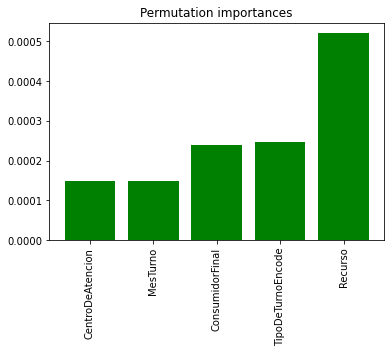

In [104]:
plt.figure()
plt.title("Permutation importances")
plt.bar(range(X.shape[1]), r.importances_std[indices],color="g")
plt.xticks(range(X.shape[1]), labels=X_test.columns[indices],rotation=90)
plt.show()

# Calcular importancia de cada feature

Feature ranking:
CentroDeAtencion 0.030380780993485214
Recurso 0.7831726276517397
MesTurno 0.11736757131368451
ConsumidorFinal 0.012278642962325509
TipoDeTurnoEncode 0.05680037707876502


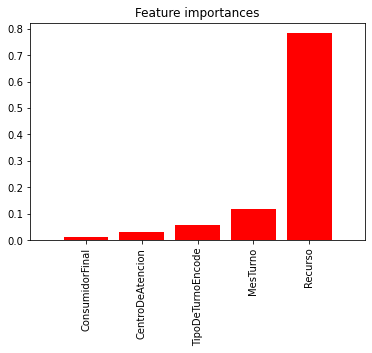

In [106]:
importances= model_rf.feature_importances_
indices = np.argsort(importances) 
print("Feature ranking:")

#std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

for f in range(X.shape[1]):
    print(X_test.columns[f], importances[f])
    
# Plot the impurity-based feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), labels=X_test.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Metricas Curvas ROC

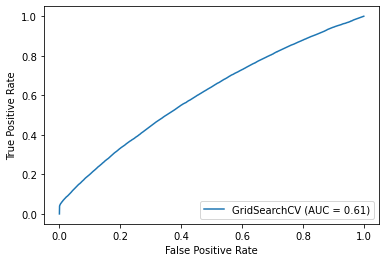

In [107]:
plot_roc_curve(rf_clf, X_test, y_test);

**El RandomForestClassifier NO es bueno de acuerdo a este grafico ya que llega a un valor alto de falso positivos para una tasa de verdaderos positivos alta**

In [108]:
y_proba = rf_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [109]:
roc_auc_score(y_test, rf_clf.predict(X_test))

0.5738222560883249

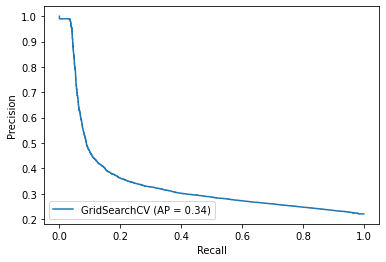

In [110]:
plot_precision_recall_curve(rf_clf, X_test, y_test)

**El RandomForestClassifier NO seria bueno de acuerdo a este grafico ya que para una precision alta el recall es 0**

In [115]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [116]:
y_test_pred = rf_clf.predict(X_test)

In [117]:
f1_score(y_test, y_test_pred)

0.36601454841187375

<AxesSubplot:>

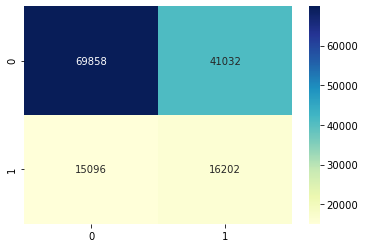

In [118]:
cm_train=confusion_matrix(y_test, y_test_pred)
s.heatmap(cm_train, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo NO es bueno en la clasificacion de las clases**

# BayesSearchCV

In [119]:
model_rf = RandomForestClassifier()
search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 20), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(100, 500)
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.85:
        print('Interrupting!')
        return True

forest_bayes_search = BayesSearchCV(model_rf, search_space, n_iter=3, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=3, verbose= 4)

forest_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished


best score: 0.7871447086837267
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best score: 0.7871447086837267
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


best score: 0.7875064050396359


BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=3, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=6, high=20, prior='uniform', transform='identity'),
                             'max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='identity'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='identity')},
              verbose=4)

In [120]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', True),
             ('max_depth', 18),
             ('max_features', 'log2'),
             ('min_samples_leaf', 8),
             ('min_samples_split', 7),
             ('n_estimators', 164)])

In [121]:
forest_bayes_search.best_estimator_

RandomForestClassifier(max_depth=18, max_features='log2', min_samples_leaf=8,
                       min_samples_split=7, n_estimators=164)

In [122]:
forest_bayes_search.best_score_

0.7875064050396359

# Resultados con menos features segun No supervisado

**Mejores parametros, estimadores y mejor score de Bayes SearchCV**

**OrderedDict([('bootstrap', True),
             ('max_depth', 18),
             ('max_features', 'log2'),
             ('min_samples_leaf', 8),
             ('min_samples_split', 7),
             ('n_estimators', 164)])**
             
**RandomForestClassifier(max_depth=18, max_features='log2', min_samples_leaf=8,
                       min_samples_split=7, n_estimators=164)**             

**Mejor Score Bayes SearchCV 0.7841033030302099**

# Resultados con aprendizaje supervisado 

**Mejores parametros, estimadores y mejor score de Bayes SearchCV**

**OrderedDict([('bootstrap', False),
             ('max_depth', 20),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 7),
             ('min_samples_split', 4),
             ('n_estimators', 165)])**
             
**RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_leaf=7, min_samples_split=4,
                       n_estimators=165)**
                       
**Mejor Score Bayes SearchCV  0.7817529931887099**

**Observamos que casi no hay diferencia con la disminución de features**

# Metricas Curvas ROC

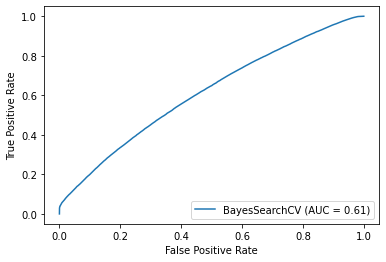

In [127]:
plot_roc_curve(forest_bayes_search, X_test, y_test);

**El Bayer Search CV NO es bueno de acuerdo a este grafico ya que llega a un valor alto de falso positivos para una tasa de verdaderos positivos alta**

In [128]:
y_proba = forest_bayes_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [129]:
roc_auc_score(y_test, forest_bayes_search.predict(X_test))

0.5184687067170373

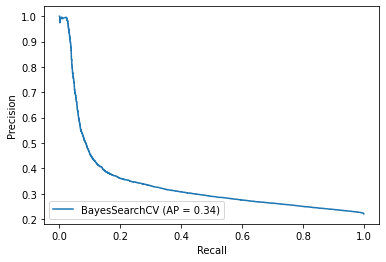

In [130]:
plot_precision_recall_curve(forest_bayes_search, X_test, y_test)

**El Bayes Search CV NO seria bueno de acuerdo a este grafico ya que para una precision alta el recall es 0** 

In [131]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [132]:
y_test_pred=forest_bayes_search.predict(X_test)

In [134]:
f1_score(y_test, y_test_pred )

0.07390639339247476

In [135]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

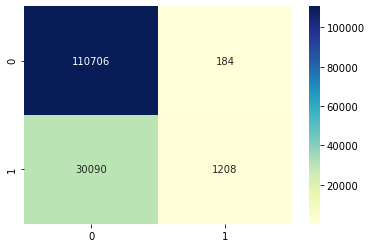

In [136]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo NO clasifica bien las clases**

# Modelo Boosting with xgboost

In [137]:
clf = xgb.XGBClassifier(objective ='binary:logistic', booster ='gbtree', learning_rate = 0.1,
                          max_depth = 10, alpha = 5, n_estimators = 50, cv=3, scoring='accuracy',n_jobs=-1, verbose = 3)

In [138]:
clf.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        verbose=True) 

[00:25:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { cv, scoring, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60090	validation_1-auc:0.59766
[1]	validation_0-auc:0.60297	validation_1-auc:0.59878
[2]	validation_0-auc:0.60514	validation_1-auc:0.60066
[3]	validation_0-auc:0.60594	validation_1-auc:0.60173
[4]	validation_0-auc:0.60650	validation_1-auc:0.60243
[5]	validation_0-auc:0.61048	validation_1-auc:0.60635
[6]	validation_0-auc:0.61231	validation_1-auc:0.60751
[7]	validation_0-auc:0.61315	validation_1-auc:0.60833
[8]	validation_0-auc:0.61314	validation_1-auc:0.60835
[9]	validation_0-auc:0.61382	validation_1-auc:0.60863
[10]	validation_0-auc:0.61631	validation_1-auc:0.61090
[11]	va

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=5, reg_lambda=1, scale_pos_weight=1, scoring='accuracy',
              subsample=1, tree_method='exact', validate_parameters=1,
              verbose=3, verbosity=None)

In [139]:
evals_result = clf.evals_result()

In [140]:
y_pred = clf.predict(X)

In [141]:
pred=[round(value) for value in y_pred]

In [142]:
acc_score = accuracy_score(y, y_pred)

In [143]:
print('Boosting accuracy: ', acc_score)

Boosting accuracy:  0.7888758075610075


# Metricas Curvas ROC

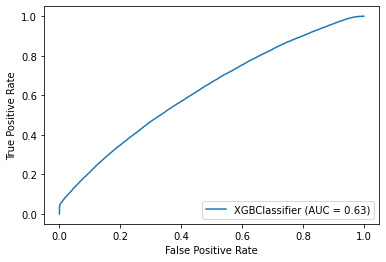

In [144]:
plot_roc_curve(clf, X_test, y_test);

**El gráfico muestra que el modelo xgboost NO es bueno de acuerdo a este grafico ya que llega a un valor alto de falso positivos para una tasa de verdaderos positivos alta**

In [145]:
y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [146]:
roc_auc_score(y_test, clf.predict(X_test))

0.5195249992305443

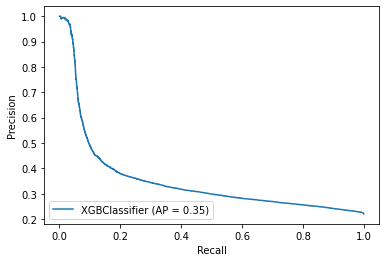

In [147]:
plot_precision_recall_curve(clf, X_test, y_test)

**El grafico muestra que el modelo NO seria bueno de acuerdo a este grafico ya que para una precision alta el recall es 0**

In [148]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [149]:
y_test_pred = clf.predict(X_test)

In [167]:
f1_score(y_test, y_test_pred)

0.2791944192645726

In [151]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

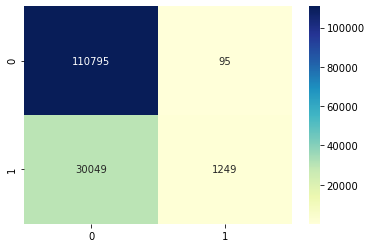

In [152]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo tiene errores considerables en la prediccion de la clase 1**

# Permutation_importance feature para boosting

In [153]:
r = permutation_importance(clf, X_test, y_test, random_state=0)

In [154]:
indices = np.argsort(r.importances_std)
for f in range(X.shape[1]):
    print(X_test.columns[f], r.importances_std[f])

CentroDeAtencion 3.4853888354448745e-05
Recurso 0.00011441021412587714
MesTurno 6.454999806218335e-05
ConsumidorFinal 0.00011604141676450661
TipoDeTurnoEncode 0.0002015695740025609


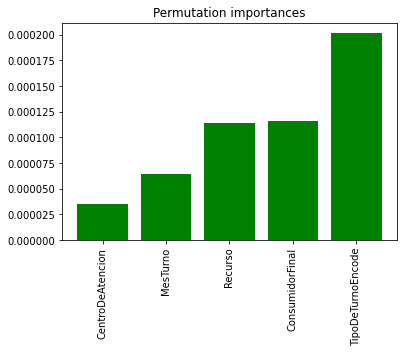

In [155]:
plt.figure()
plt.title("Permutation importances")
plt.bar(range(X.shape[1]), r.importances_std[indices],color="g")
plt.xticks(range(X.shape[1]), labels=X_test.columns[indices],rotation=90)
plt.show()

# Feature importances para boosting

Feature ranking:
CentroDeAtencion 0.1646348
Recurso 0.20680827
MesTurno 0.029360913
ConsumidorFinal 0.09785943
TipoDeTurnoEncode 0.5013366


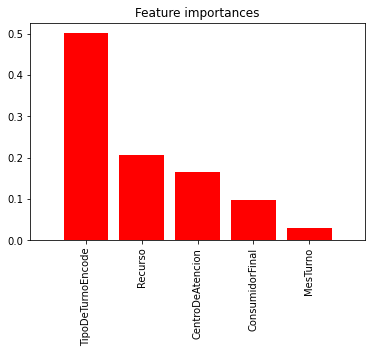

In [156]:
importances= clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print(X_test.columns[f], importances[f])
    
# Plot the impurity-based feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), labels=X_test.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


# Modelo Linear SVC

In [157]:
svc = make_pipeline(StandardScaler(), LinearSVC (loss = 'hinge', multi_class = 'crammer_singer', class_weight = 'balanced' , random_state=42 ))

In [158]:
svc.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(class_weight='balanced', loss='hinge',
                           multi_class='crammer_singer', random_state=42))])

In [159]:
predictions = svc.predict(X_test)
print ('Accuracy: %d ' % ((np.sum(y_test == predictions))/float(y.size)*100))

Accuracy: 18 


# Metricas Curvas ROC

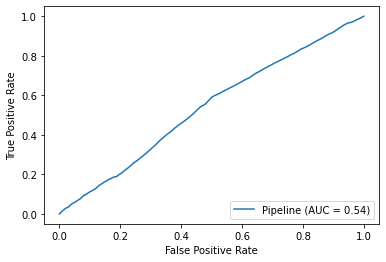

In [160]:
plot_roc_curve(svc, X_test, y_test);

**El gráfico muestra que el modelo Linear SVC NO es bueno de acuerdo a este grafico ya que llega a un valor alto de falso positivos para una tasa de verdaderos positivos alta**

In [161]:
roc_auc_score(y_test, svc.predict(X_test))

0.5155709291165437

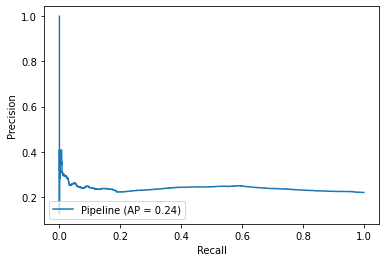

In [162]:
plot_precision_recall_curve(svc, X_test, y_test)

**El modelo Linear SVC NO seria bueno de acuerdo a este grafico ya que para una precision alta el recall es 0**

In [163]:
y_test_pred = svc.predict(X_test)

In [164]:
f1_score(y_test, y_test_pred)

0.2791944192645726

In [165]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

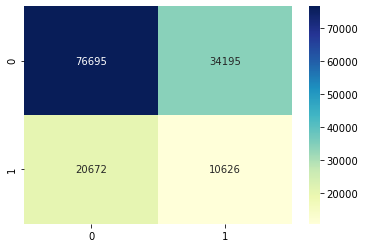

In [166]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo clasifica incorrectamente las dos clases**